# SETI  Breakthrough Listen - EDA, Training, and Inference
<img src="images/header.png">

In [1]:
import os
import warnings; warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from fastai.vision.all import *
colors = ["#a2c4e0", "#82a4e3", "#52688f", "#f7cb2d"] 

## Exploratory Data Analysis
Lets inspect the dimensions of a data file and plot an example spectrogram.

In [2]:
dataset_path = Path('/SETI/data/')
file_path = os.path.join(dataset_path,"train","0","0ffdf66b057a.npy")
data = np.load(file_path)
print(np.shape(data))
print("6 observations in the cadence: A-B-A-C-A-D")
print("273 x 256 = dimensions of the spectrogram")

(6, 273, 256)
6 observations in the cadence: A-B-A-C-A-D
273 x 256 = dimensions of the spectrogram


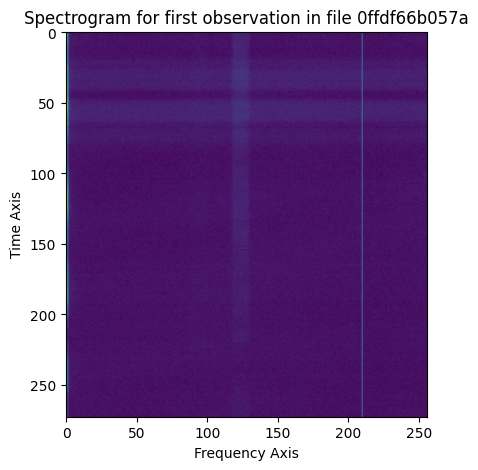

In [3]:
plt.figure(figsize=(5,5))
plt.imshow(data[0].astype(np.float32))
plt.xlabel('Frequency Axis')
plt.ylabel('Time Axis')
plt.title('Spectrogram for first observation in file 0ffdf66b057a')
plt.show()

From this discussion topic https://www.kaggle.com/c/seti-breakthrough-listen/discussion/239339, the time axis is confirmed to be the axis with 273 in length and that it covers the full five minutes and that the frequency axis (length 256) encompasses approximately 0.7 MHz of bandwidth. the competition organizer further explains that these snippets are extracted from the mid-resolution files (~1.07 second time resolution, 2.86 kHz frequency resolution - see table 4 of Lebofsky et al. in the references directory of the repository for more detail).

Next, for records in the train and test sets, create a column that details file paths:

In [4]:
train = pd.read_csv(os.path.join(dataset_path,"train_labels.csv"))
test = pd.read_csv(os.path.join(dataset_path,"sample_submission.csv"))

def get_train_file_path(image_id):
    return os.path.join(dataset_path,"train/{}/{}.npy").format(image_id[0], image_id)

def get_test_file_path(image_id):
    return os.path.join(dataset_path,"test/{}/{}.npy").format(image_id[0], image_id)

train['file_path'] = train['id'].apply(get_train_file_path)
test['file_path'] = test['id'].apply(get_test_file_path)

display(train.head())
display(test.head())

,id,target,file_path
0,00034abb3629,0,/SETI/data/train/0/00034abb3629.npy
1,0004300a0b9b,0,/SETI/data/train/0/0004300a0b9b.npy
2,000453852fda,0,/SETI/data/train/0/000453852fda.npy
3,00047dfc96a9,0,/SETI/data/train/0/00047dfc96a9.npy
4,0004be0baf70,0,/SETI/data/train/0/0004be0baf70.npy


,id,target,file_path
0,00034db451c4,0.5,/SETI/data/test/0/00034db451c4.npy
1,0006316b5ca0,0.5,/SETI/data/test/0/0006316b5ca0.npy
2,0006a953d21b,0.5,/SETI/data/test/0/0006a953d21b.npy
3,0008a33d6695,0.5,/SETI/data/test/0/0008a33d6695.npy
4,00095b5119fc,0.5,/SETI/data/test/0/00095b5119fc.npy


In the training set, let's take a look at the distribution of target labels. As expected for the problem space, the data is heavily imbalanced:

Number of records without technosignatures: 45471
Number of records with technosignatures: 4694


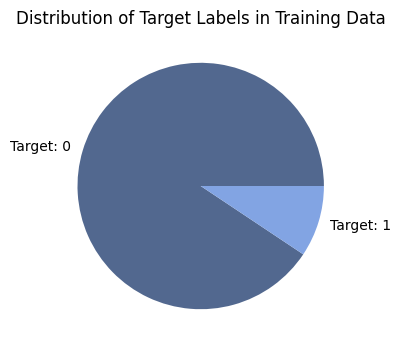

In [5]:
print("Number of records without technosignatures: "+str(train["target"].value_counts()[0]))
print("Number of records with technosignatures: "+str(train["target"].value_counts()[1]))

plt.figure(figsize=(4,4))
plt.pie(train["target"].value_counts(), labels=["Target: 0", "Target: 1"], colors=[colors[2], colors[1]])
plt.title("Distribution of Target Labels in Training Data")
plt.show()

So far we've examined the data within singular spectrograms but recall each data file is actually a cadence of six observations. Lets now construct some functions to explore these cadenced spectrograms. The initial cadencesplotted fall into the dominant class with no technosignatures present but it is neat to see examples of the radio frequency interference and effects that we can see in the data and will need to avoid as triggering a false positive. Later in the notebook, some cadences with technosignatures present are specifically identified in the training set and plotted to reveal the sorts of patterns that we hope to identify.

In [6]:
def show_cadence(filename: str, label: int) -> None:
    plt.figure(figsize=(8, 5))
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {os.path.basename(filename)[:-4]}  TARGET: {label}", fontsize=14)
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
        if i ==5:
            plt.xlabel("Frequency")
        plt.xticks([])
    plt.show()

### Plotting Cadences
Let's plot a cadence of collection. In this case, there is no technosignature present, but the sample offers a nice example of localized interference in a collection that could trigger a false alarm if not addressed properly.

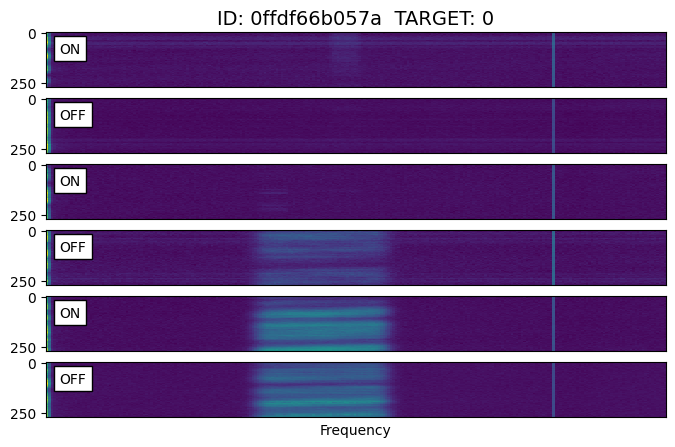

In [7]:
show_cadence(file_path, 0)

#### Samples without Technosignatures
Here are some more examples of collections without a technosignatrure present, however, often with interference present.

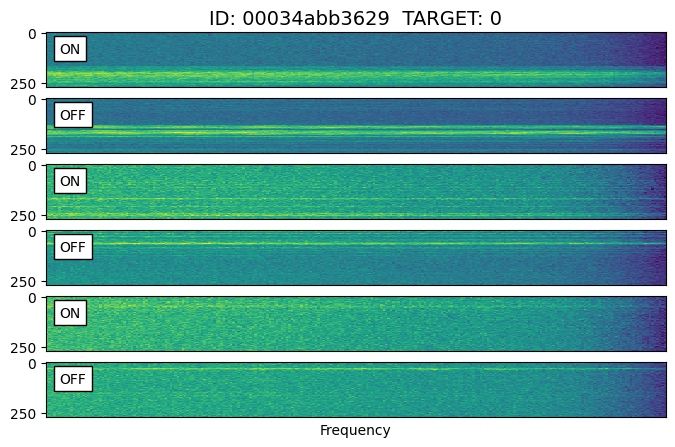

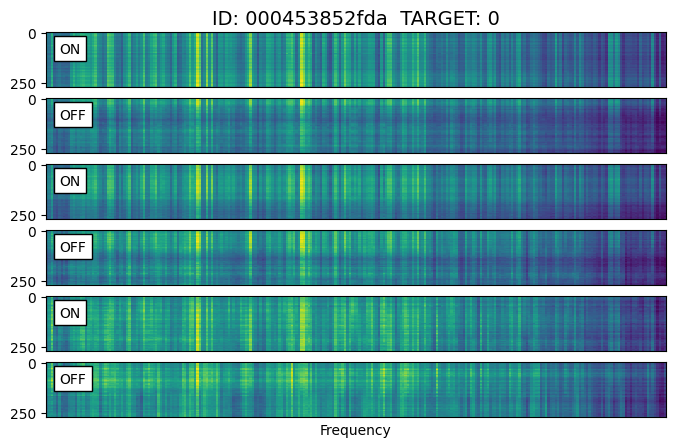

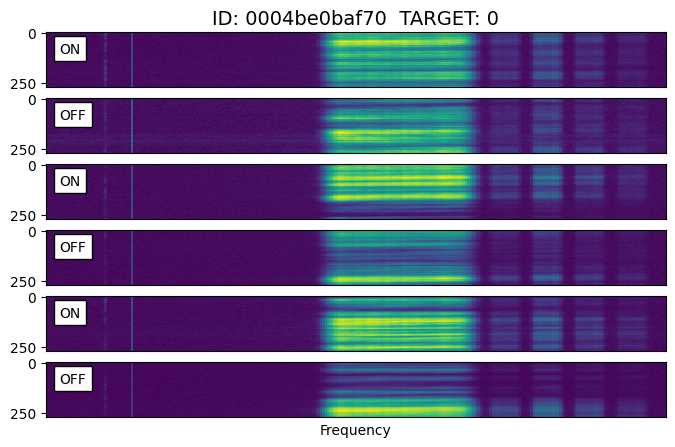

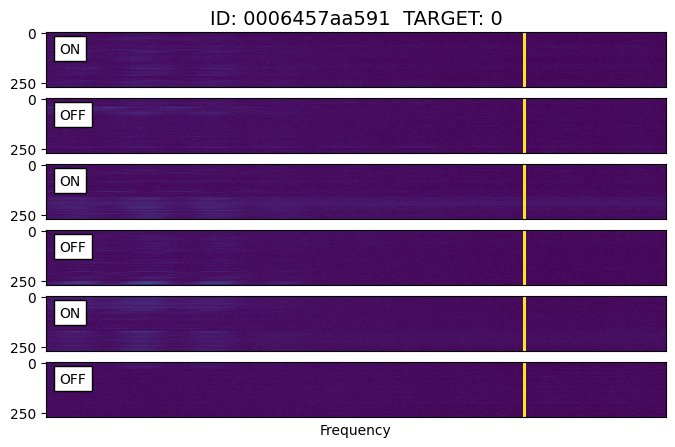

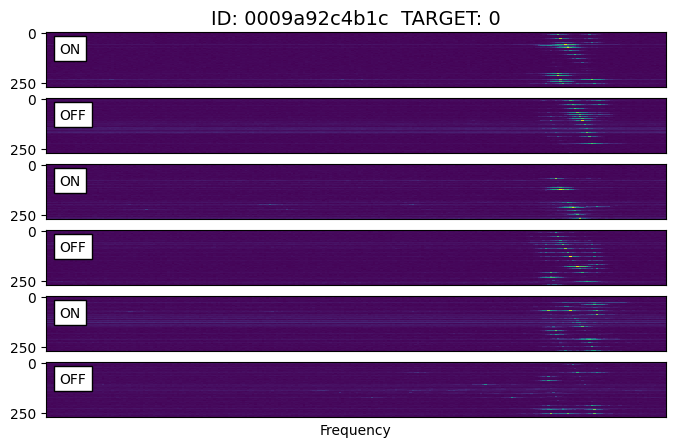

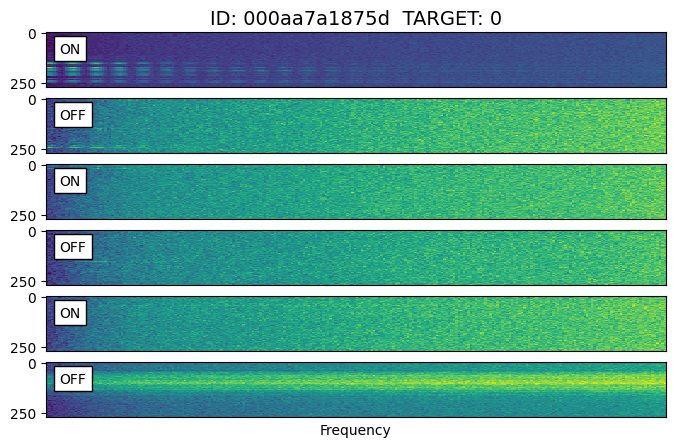

In [8]:
for idx in [0,2,4,6,8,10]:
    show_cadence(train["file_path"][idx],train["target"][idx])

#### Samples with Technosignatures Present
And here are some examples within the training data with technosignatures present. Note the relative SNR of some technosignatures which will drive the difficulty of detection.

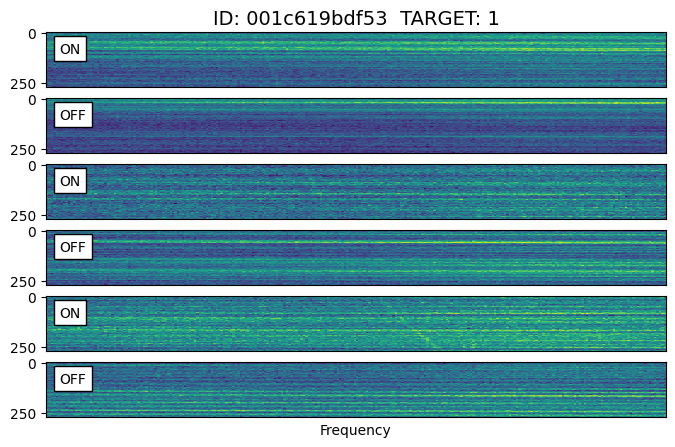

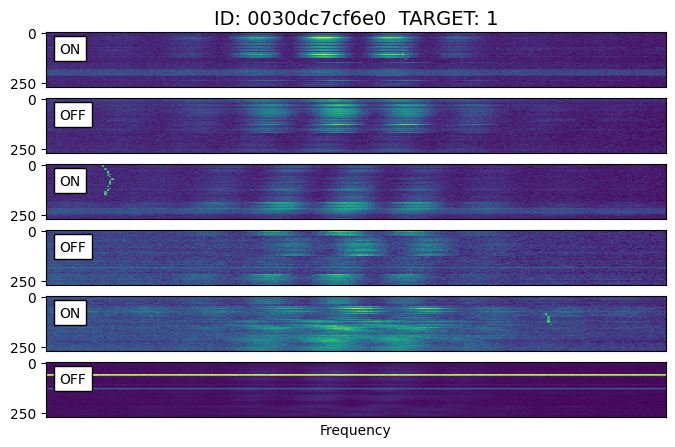

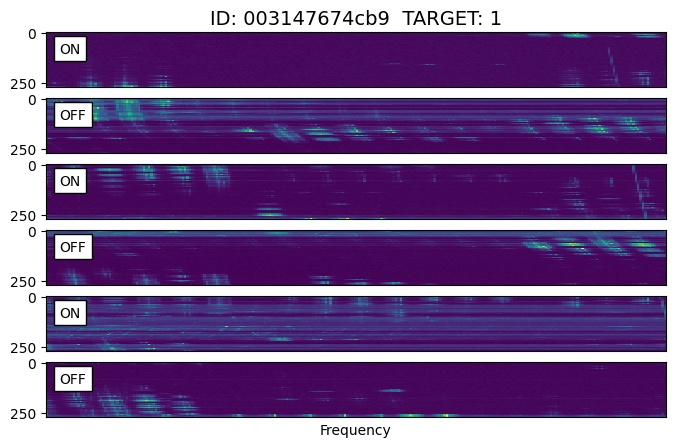

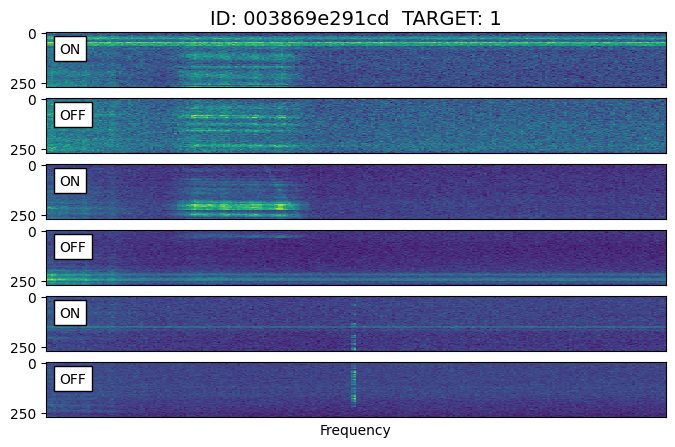

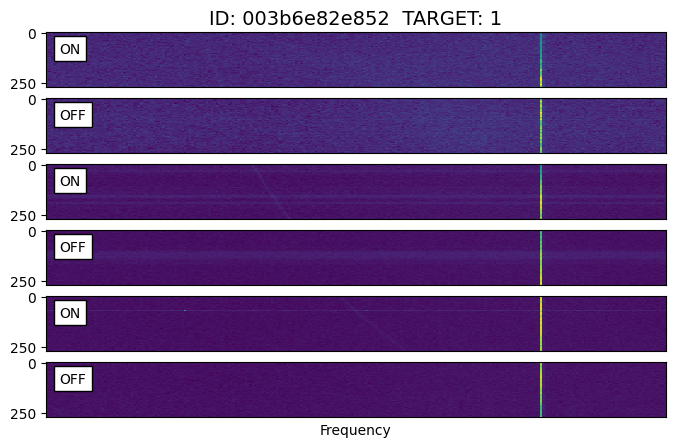

In [9]:
sigs = train[train["target"]==1].reset_index()
for idx in range(0,5):
    show_cadence(sigs["file_path"][idx],sigs["target"][idx])

## Pytorch Implementation
We can make a simple dataset class as shown below. The following class allows you to use channel vs. spatial approaches, and 3- vs. 6-channel apporaches, which were the main approaches discussed on the forums for this competition. For this notebook, we will train with the spatial approach.

In [10]:
class SETIDataset:
    def __init__(self, df, spatial=True, sixchan=True):
        self.df = df
        self.spatial = spatial
        self.sixchan = sixchan
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        label = self.df.iloc[index].target
        filename = self.df.iloc[index].path
        data = np.load(filename).astype(np.float32)
        if not self.sixchan: data = data[::2].astype(np.float32)
        if self.spatial:
            data = np.vstack(data).transpose((1, 0))
            data = cv2.resize(data, dsize=(256,256))     
            data_tensor = torch.tensor(data).float().unsqueeze(0)
        else:
            data = np.transpose(data, (1,2,0))
            data = cv2.resize(data, dsize=(256,256))     
            data = np.transpose(data, (2, 0, 1)).astype(np.float32)
            data_tensor = torch.tensor(data).float()
            
        return (data_tensor, torch.tensor(label))

Take the training data corpus into a DataFrame and split the DataFrame into `train_df` and `valid_df` in a reproducible manner.

In [11]:
df = pd.read_csv(dataset_path/'train_labels.csv')
#adding the path for each id for easier processing
df['path'] = df['id'].apply(lambda x: str(dataset_path/'train'/x[0]/x)+'.npy') 
df.head()

train_df, valid_df = train_test_split(df, test_size=0.2, random_state=999)

train_ds = SETIDataset(train_df)
valid_ds = SETIDataset(valid_df)

bs = 128
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bs, num_workers=8)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bs, num_workers=8)

Now we will use fastai functionality to wrap the dataloaders into the `DataLoaders` class, which gathers all the dataloaders into a single object which can be passed into fastai's `Learner`. You can see how flexible fastai really is: you can use any custom PyTorch DataLoader!

In [12]:
dls = DataLoaders(train_dl, valid_dl)

## Training

We will use Zachary Mueller's `timm_learner` function to create an already-instantiated Learner object with the `DataLoaders` and an appropriately defined CNN model taken from Ross Wightman's amazing timm package. The code for `timm_learner` (see the hidden cell below) is based on fastai's `cnn_learner` function. We can telltimm_learner what CNN backbone we want to use, as well as the number of input and output channels, and fastai automatically defines the appropriate model. We also pass in the metrics and the loss function. Fastai's default optimizer is AdamW. Finally, we can also use mixed precision training easily.

We'll use a simple ImageNet-pretrained ResNext50_32x4d model.

In [13]:
from timm import create_model
from fastai.vision.learner import _update_first_layer

def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")
        
def create_timm_model(arch:str, n_out, cut=None, pretrained=True, n_in=3, init=nn.init.kaiming_normal_, custom_head=None,
                     concat_pool=True, **kwargs):
    "Create custom architecture using `arch`, `n_in` and `n_out` from the `timm` library"
    body = create_timm_body(arch, pretrained, None, n_in)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children()))
        head = create_head(nf, n_out, concat_pool=concat_pool, **kwargs)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

def timm_learner(dls, arch:str, loss_func=None, pretrained=True, cut=None, splitter=None,
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner from `dls` and `arch` using the `timm` library"
    if config is None: config = {}
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = create_timm_model(arch, n_out, default_split, pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=default_split, **kwargs)
    if pretrained: learn.freeze()
    return learn

def roc_auc(preds,targ):
    try: return roc_auc_score(targ.cpu(),preds.squeeze().cpu())
    except: return 0.5

learn = timm_learner(dls,'resnext50_32x4d',pretrained=True,n_in=1,n_out=1,metrics=[roc_auc], opt_func=ranger, loss_func=BCEWithLogitsLossFlat()).to_fp16()

fastai provides a useful function to help determine the most optimal learning rate:

SuggestedLRs(valley=0.015848932787775993)

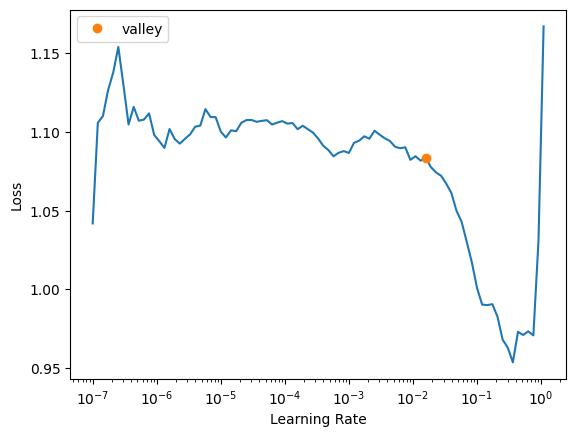

In [14]:
learn.lr_find()

The idea is that the learning rate where the loss decreases the most is likely the best learning rate. In this case, this is around ~2.5e-2.

Let's fine-tune the pretrained model using fastai's fit_one_cycle function to train the frozen pretrained model with a one-cycle learning rate schedule. I use high weight decay regularization to prevent overfitting.

epoch,train_loss,valid_loss,roc_auc,time
0,0.203180,0.151708,0.927349,01:03
1,0.100808,0.103205,0.953477,01:07
2,0.063118,0.086149,0.960315,01:06


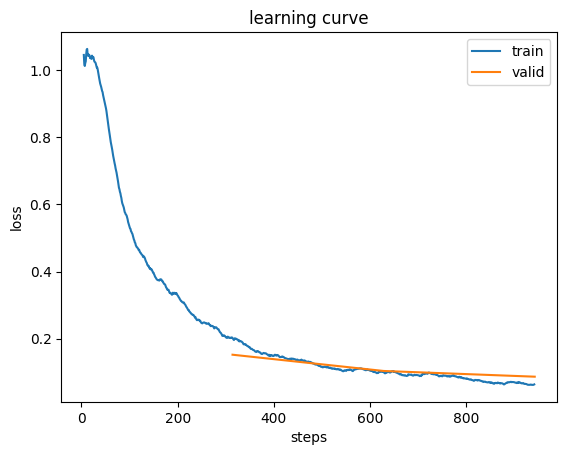

In [15]:
learn.fit_one_cycle(3, 0.1, cbs=[ReduceLROnPlateau()])
learn.recorder.plot_loss()
learn = learn.to_fp32()

Let's save our model if needed for later:

In [16]:
learn.save('resnext50_32x4d-3epochs')
#learn = learn.load('resnext50_32x4d-3epochs')  # use this to load weights manually later if needed

Path('models/resnext50_32x4d-3epochs.pth')

## Inference
Inference is also quite trivial. Let's load our CSV file and create our dataloader.

In [17]:
test_df = pd.read_csv(dataset_path/'sample_submission.csv')
test_df['path'] = test_df['id'].apply(lambda x: str(dataset_path/'test'/x[0]/x)+'.npy')
test_ds = SETIDataset(test_df)

bs = 128
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=bs, num_workers=8, shuffle=False)

While fastai provides inference functions if we use their specific data API, in this case we used plain PyTorch dataloaders. So we'll just have to iterate over the dataloader and apply the model:

In [18]:
preds = []
for xb, _ in tqdm(test_dl):
    with torch.no_grad(): output = learn.model(xb.cuda())
    preds.append(torch.sigmoid(output.float()).squeeze().cpu())
preds = torch.cat(preds)    

  0%|          | 0/281 [00:00<?, ?it/s]

Create the submission file and save:

In [19]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
sample_df['target'] = preds
sample_df.to_csv('/labels/submission.csv', index=False)
sample_df.head()

,id,target
0,00034db451c4,0.005010
1,0006316b5ca0,0.002625
2,0006a953d21b,0.008885
3,0008a33d6695,0.028720
4,00095b5119fc,0.007018


Number of inferences without technosignatures: 31482
Number of inferences with technosignatures: 4365


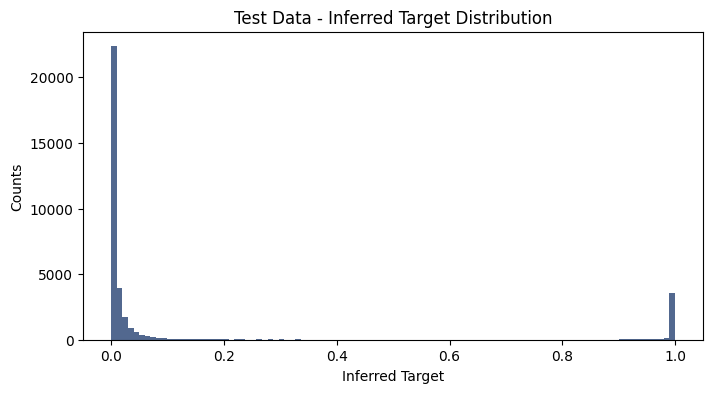

In [20]:
print("Number of inferences without technosignatures: "+str(sample_df[sample_df["target"] < 0.5]['target'].count()))
print("Number of inferences with technosignatures: "+str(sample_df[sample_df["target"] > 0.5]['target'].count()))
sample_df.hist(column="target", bins=101, figsize=(8,4), grid=False, color=colors[2])
plt.title('Test Data - Inferred Target Distribution')
plt.xlabel('Inferred Target')
plt.ylabel('Counts')
plt.show()

Without manual inspection of labeled and mislabeled records in the test and valid data sets, we can at least observe a similar distribution of labeling in the test set that we do with the train/valid set (~ 10% in both cases) which is promising.